In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sp500-daily-19862018/spx.csv


In [2]:
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
sns.set(style='whitegrid',palette ='muted')
rcParams['figure.figsize']=14, 8
np.random.seed(1)
tf.random.set_seed(1)
print("TensorFlow Version: ",tf.__version__)

TensorFlow Version:  2.2.0


In [3]:
df = pd.read_csv("../input/sp500-daily-19862018/spx.csv",parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [4]:
df.shape


(8192, 2)

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date,y=df.close,mode='lines',name='close'))
fig.update_layout(showlegend=True)
fig.show()

# Data Preprocessing


In [6]:
train_size = int(len(df)*0.8)
test_size = len(df)-train_size
train,test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(6553, 2) (1639, 2)


In [7]:
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
sc = sc.fit(train[['close']])

train['close'] = sc.transform(train[['close']])
test['close'] = sc.transform(test[['close']])

# Train And Test Split

In [8]:
def create_sequences(X,y,time_steps=1):
    Xs,ys =[],[]
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
        
    return np.array(Xs),np.array(ys)
    
    

In [9]:
time_steps=30
X_train,y_train = create_sequences(train[['close']],train.close,time_steps)
X_test,y_test = create_sequences(test[['close']],train.close,time_steps)

In [10]:
print(X_train.shape)

(6523, 30, 1)


# LSTM Autoencoder

In [11]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,RepeatVector,TimeDistributed
model = Sequential([
    LSTM(128,input_shape=(timesteps,num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128,return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
    
])
model.compile(loss='mae',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

# Train The Autoencoder

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history = model.fit(
        X_train,y_train,epochs=100,
    batch_size=32,validation_split = 0.1,callbacks=[es],shuffle=False
)

Epoch 1/100
184/184 [==============================] - 2s 11ms/step - loss: 0.1650 - accuracy: 0.0000e+00 - val_loss: 0.1764 - val_accuracy: 0.0000e+00
Epoch 2/100
184/184 [==============================] - 1s 8ms/step - loss: 0.1136 - accuracy: 0.0000e+00 - val_loss: 0.0569 - val_accuracy: 0.0000e+00
Epoch 3/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0902 - accuracy: 0.0000e+00 - val_loss: 0.0510 - val_accuracy: 0.0000e+00
Epoch 4/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0806 - accuracy: 0.0000e+00 - val_loss: 0.0539 - val_accuracy: 0.0000e+00
Epoch 5/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0763 - accuracy: 0.0000e+00 - val_loss: 0.0447 - val_accuracy: 0.0000e+00
Epoch 6/100
184/184 [==============================] - 1s 8ms/step - loss: 0.0778 - accuracy: 0.0000e+00 - val_loss: 0.0468 - val_accuracy: 0.0000e+00
Epoch 7/100
184/184 [==============================] - 1s 7ms/step - loss: 0.0753 - accuracy:

# Plot Metrics and Evaluate The Model

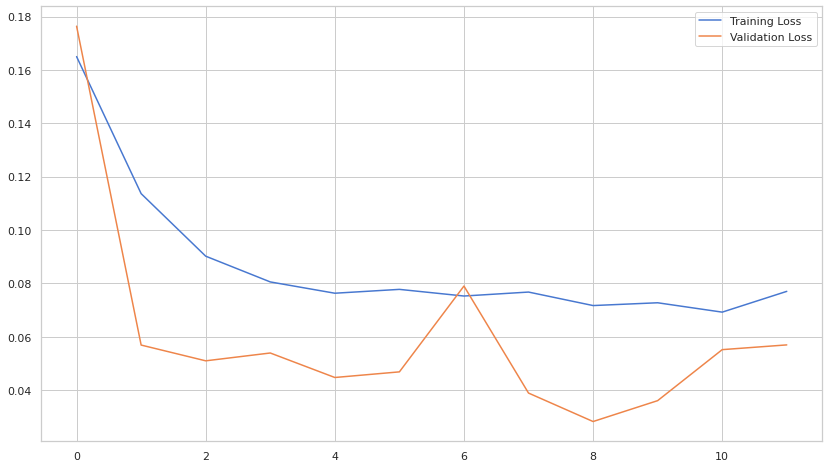

In [14]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [15]:
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred-X_train),axis=1), columns=['Error'])

In [16]:
model.evaluate(X_test,y_test)

51/51 [==============================] - 0s 4ms/step - loss: 3.6700 - accuracy: 0.0000e+00


[3.670008659362793, 0.0]

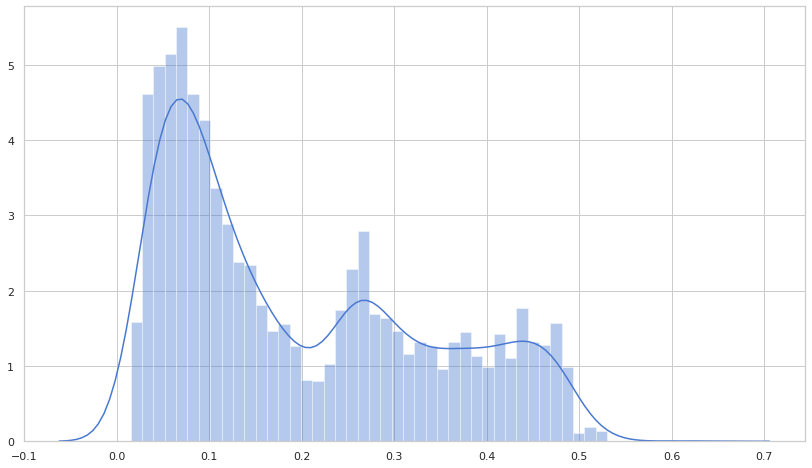

In [17]:
sns.distplot(train_mae_loss,bins=50,kde=True)

In [18]:
threshold =0.65

In [19]:
X_test_pred = model.predict(X_test)

In [20]:
test_mae_loss = np.mean(np.abs(X_test_pred-X_test),axis=1)

In [21]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anamoly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [22]:
test_score_df.head()

,date,close,loss,threshold,anamoly
6583,2012-02-08,1.216856,0.056148,0.65,False
6584,2012-02-09,1.221625,0.056178,0.65,False
6585,2012-02-10,1.199313,0.056055,0.65,False
6586,2012-02-13,1.221194,0.056090,0.65,False
6587,2012-02-14,1.218150,0.054610,0.65,False


In [23]:
test_score_df.tail()

,date,close,loss,threshold,anamoly
8187,2018-06-25,4.493228,0.734083,0.65,True
8188,2018-06-26,4.507583,0.779650,0.65,True
8189,2018-06-27,4.451431,0.789795,0.65,True
8190,2018-06-28,4.491406,0.819372,0.65,True
8191,2018-06-29,4.496343,0.808718,0.65,True


In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date,y=test_score_df.loss,mode='lines',name='Test Loss'))
fig.add_trace (go.Scatter(x=test[time_steps:].date,y=test_score_df.threshold,mode='lines',name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()



In [25]:
anamolies = test_score_df[test_score_df.anamoly == True]
anamolies.head()

,date,close,loss,threshold,anamoly
7474,2015-08-25,2.457439,0.724154,0.65,True
7475,2015-08-26,2.632149,0.791537,0.65,True
7476,2015-08-27,2.745147,0.699877,0.65,True
8089,2018-02-02,4.601217,0.653421,0.65,True
8090,2018-02-05,4.329949,0.735310,0.65,True


In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date,y=sc.inverse_transform(test[time_steps:].close),mode='lines',name='Close Price'))
fig.add_trace (go.Scatter(x=anamolies.date,y=sc.inverse_transform(anamolies.close),mode='markers',name='Ano'))
fig.update_layout(showlegend=True)
fig.show()
